<a href="https://colab.research.google.com/github/ygeszvain/projects/blob/master/Feature_Importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Environment Configuration**

In [78]:
! pip install rfpimp
! pip install eli5

     |████████████████████████████████| 102kB 4.4MB/s 


In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import numpy as np  # arrays and math functions
# visualisations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib

%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

sns.set_style("whitegrid")
sns.set(rc = {'figure.figsize':(15, 10)})
matplotlib.rcParams['figure.figsize'] = (15, 10)

In [0]:
# udfs ----

# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 20)

**Data source - Car Features and MSRP (Kaggle)**

In [62]:
data = pd.read_csv("data.csv")
data.describe()

,Year,Engine HP,Engine Cylinders,Number of Doors,highway MPG,city mpg,Popularity,MSRP
count,11914.000000,11845.00000,11884.000000,11908.000000,11914.000000,11914.000000,11914.000000,1.191400e+04
mean,2010.384338,249.38607,5.628829,3.436093,26.637485,19.733255,1554.911197,4.059474e+04
std,7.579740,109.19187,1.780559,0.881315,8.863001,8.987798,1441.855347,6.010910e+04
min,1990.000000,55.00000,0.000000,2.000000,12.000000,7.000000,2.000000,2.000000e+03
25%,2007.000000,170.00000,4.000000,2.000000,22.000000,16.000000,549.000000,2.100000e+04
50%,2015.000000,227.00000,6.000000,4.000000,26.000000,18.000000,1385.000000,2.999500e+04
75%,2016.000000,300.00000,6.000000,4.000000,30.000000,22.000000,2009.000000,4.223125e+04
max,2017.000000,1001.00000,16.000000,4.000000,354.000000,137.000000,5657.000000,2.065902e+06


Re-assigned MSRP to be our Target

In [0]:
data = data.rename(index=str, columns={"MSRP": "target"})

Create a feature names dataframe

In [64]:
d = {
    'feature_names':['Year','Engine HP','Engine Cylinders','Number of Doors', 'highway MPG', 'city mpg','Popularity']}
 
feature_names = pd.DataFrame(d,columns=['feature_names'])
feature_names

,feature_names
0,Year
1,Engine HP
2,Engine Cylinders
3,Number of Doors
4,highway MPG
5,city mpg
6,Popularity


**Analysis**

In [0]:
y = data[["target"]]
X = pd.DataFrame(data, columns = feature_names.feature_names)
np.random.seed(seed = 42)
X['random'] = np.random.random(size = len(X))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8, random_state = 42)

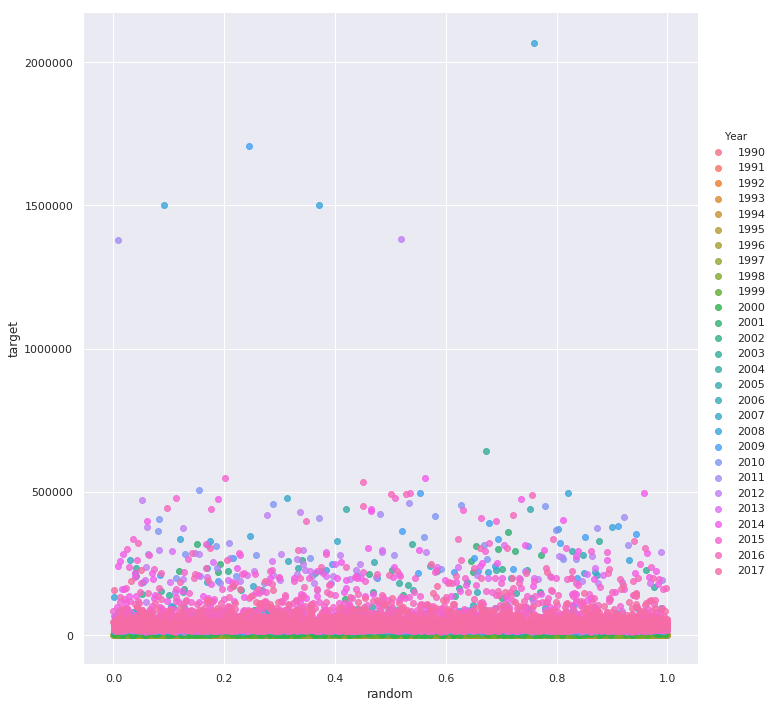

In [112]:
sns.lmplot(x='random', y='target', data=X.assign(target = y),
           fit_reg=False, # No regression line
           hue='Year',   # Color by Year
           height=10)   

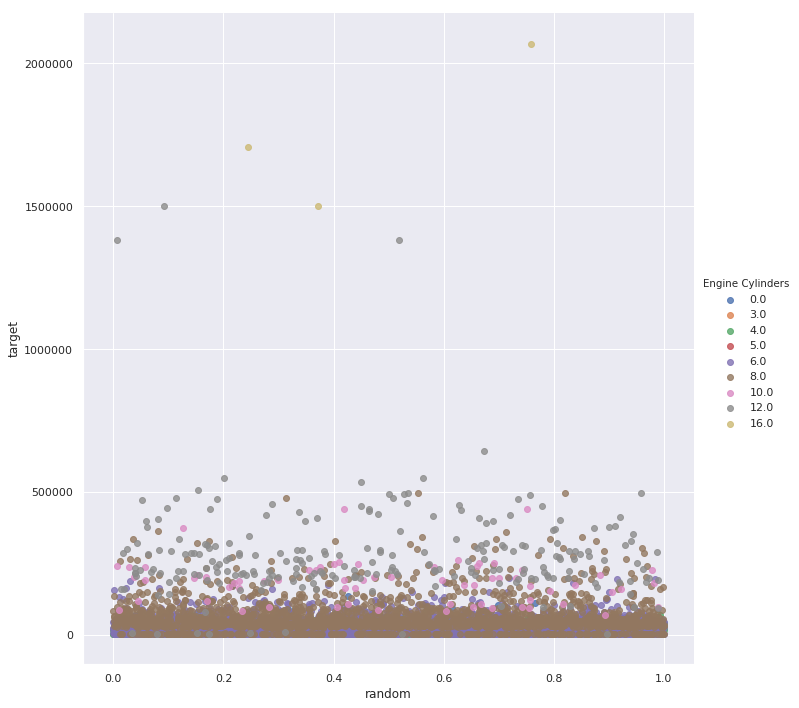

In [111]:

sns.lmplot(x='random', y='target', data=X.assign(target = y),
           fit_reg=False, # No regression line
           hue='Engine Cylinders', # Color by Engine Cylinders
           height=10)   

Text(0.5, 1.0, 'Random feature vs. target variable')

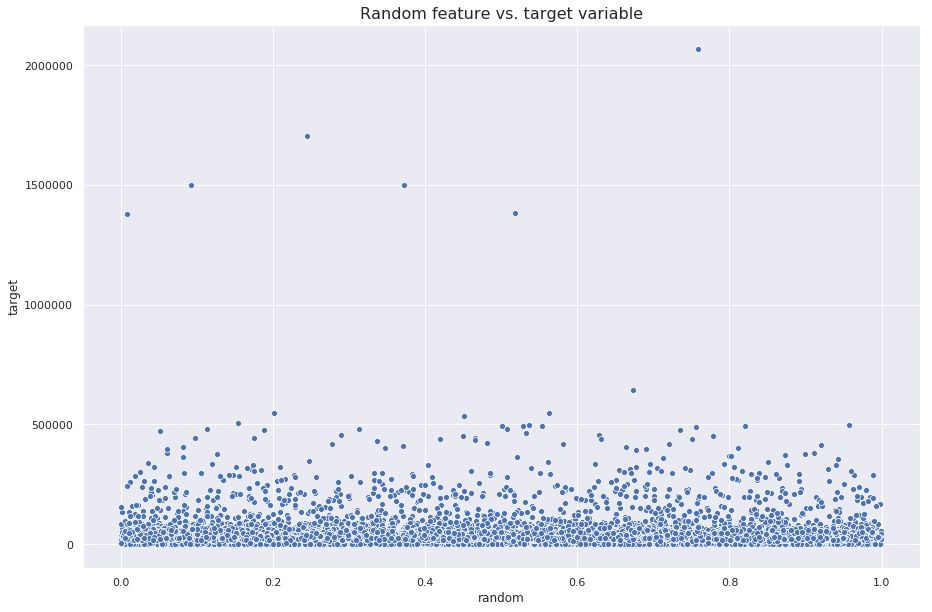

In [66]:
sns.scatterplot(x = 'random', y = 'target', data = X.assign(target = y)).set_title('Random feature vs. target variable', fontsize = 16)

Heatmap showing correlation between each feature and target

Text(0.5, 1.0, 'Correlation matrix')

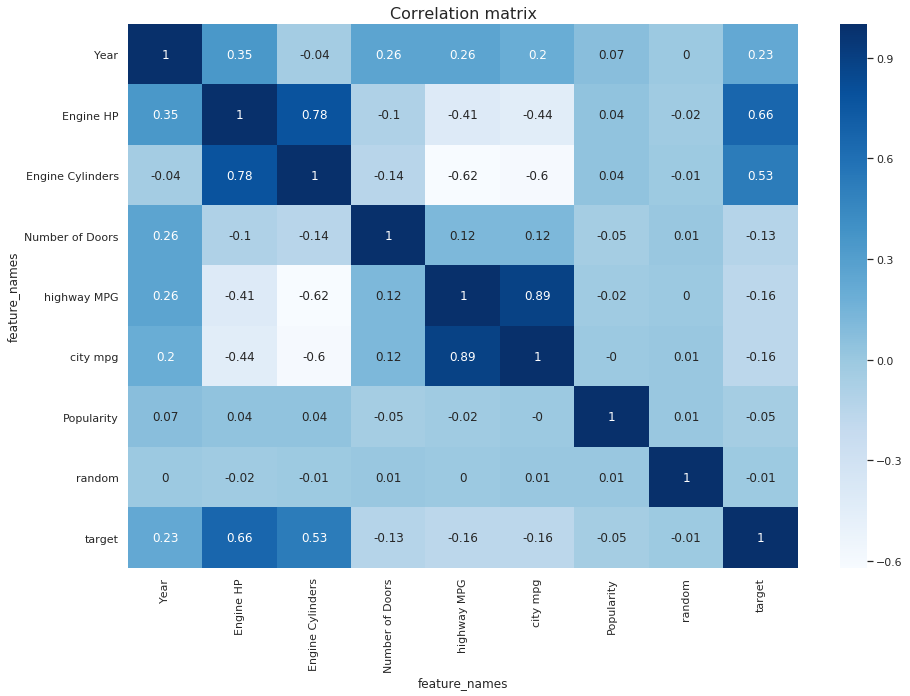

In [67]:
sns.heatmap(X.assign(target = y).corr().round(2), cmap = 'Blues', annot = True).set_title('Correlation matrix', fontsize = 16)

Correlation against target

In [90]:
#Correlation with output variable
cor_target = abs(cor["target"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

Engine HP           0.662008
Engine Cylinders    0.531312
target              1.000000
Name: target, dtype: float64

Correlation between the most important features

In [91]:
print(data[["Engine HP","Engine Cylinders"]].corr())

                  Engine HP  Engine Cylinders
Engine HP          1.000000          0.779988
Engine Cylinders   0.779988          1.000000


In [68]:
# replace NaN with 0
X_train = X_train.fillna(0)
np.any(np.isnan(X_train))

False

Random Forest Regressor Model

In [69]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)
rf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=True, random_state=42, verbose=0,
                      warm_start=False)

In [70]:
# replace NaN with 0
X_test = X_test.fillna(0)
np.any(np.isnan(X_test))

False

In [71]:
print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(X_train, y_train), 
                                                                                    rf.oob_score_,
                                                                                    rf.score(X_test, y_test)))

R^2 Training Score: 0.97 
OOB Score: 0.78 
R^2 Validation Score: 0.82


List of feature and importance score

In [72]:
base_imp = imp_df(X_train.columns, rf.feature_importances_)
base_imp

,feature,feature_importance
0,Engine HP,0.515538
1,Engine Cylinders,0.268786
2,city mpg,0.091023
3,Year,0.043432
4,Popularity,0.041218
5,highway MPG,0.017880
6,random,0.011605
7,Number of Doors,0.010519


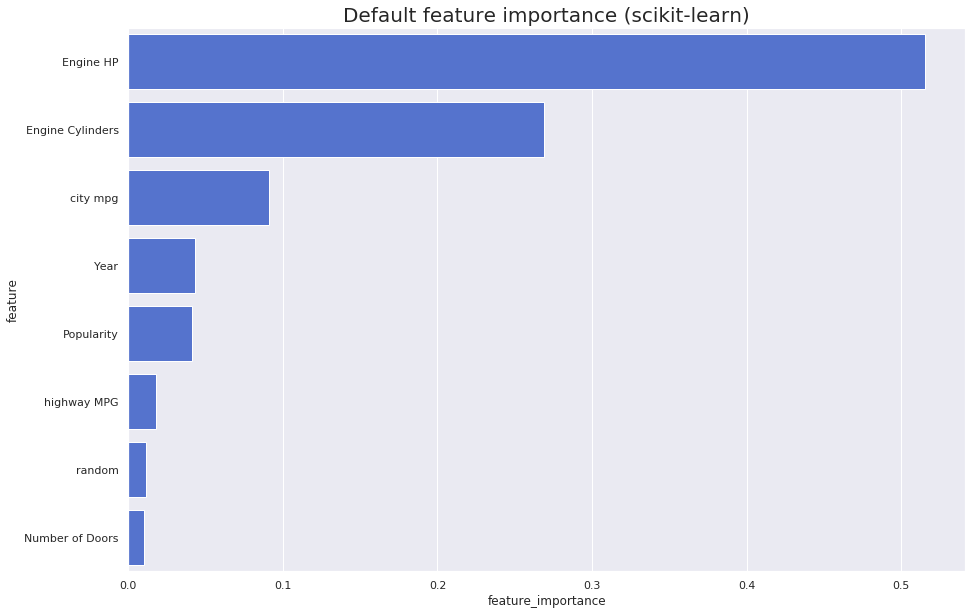

In [73]:
var_imp_plot(base_imp, 'Default feature importance (scikit-learn)')

**Permutation feature importance**

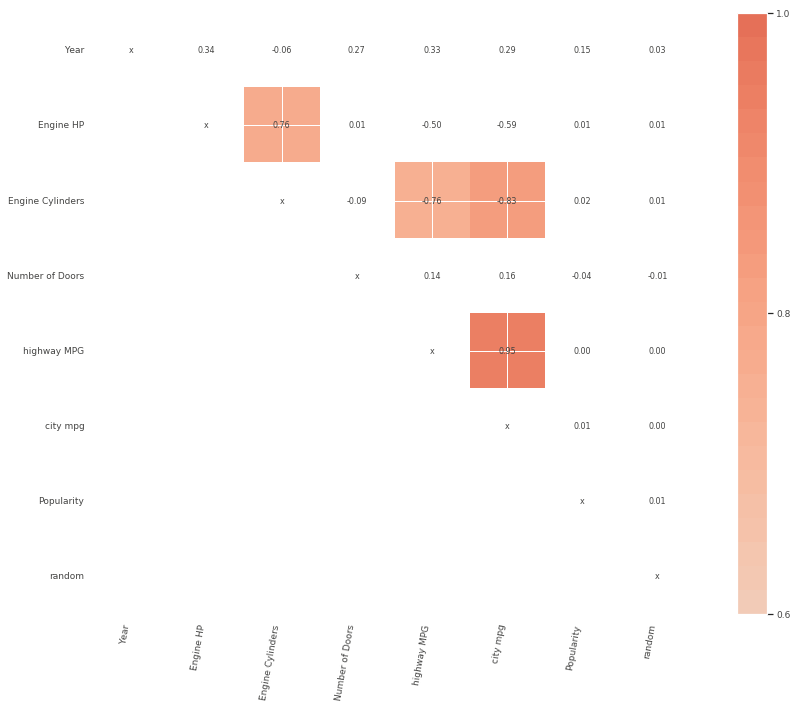

In [74]:
from rfpimp import plot_corr_heatmap
viz = plot_corr_heatmap(X_train, figsize=(15,10))
viz.view()

In [0]:
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

def r2(rf, X_train, y_train):
    return r2_score(y_train, rf.predict(X_train))

perm_imp_rfpimp = permutation_importances(rf, X_train, y_train, r2)
perm_imp_rfpimp.reset_index(drop = False, inplace = True)

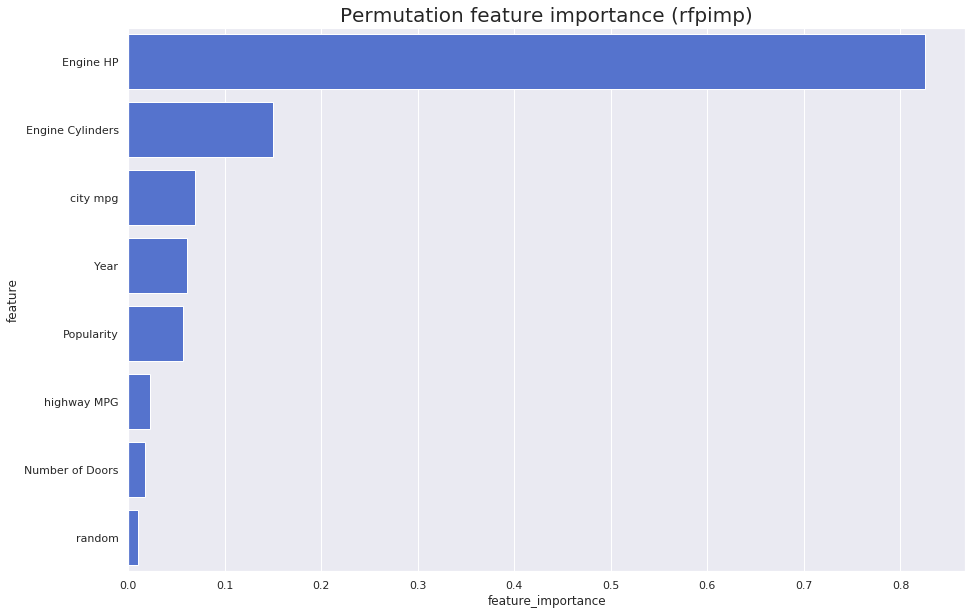

In [76]:
var_imp_plot(perm_imp_rfpimp, 'Permutation feature importance (rfpimp)')

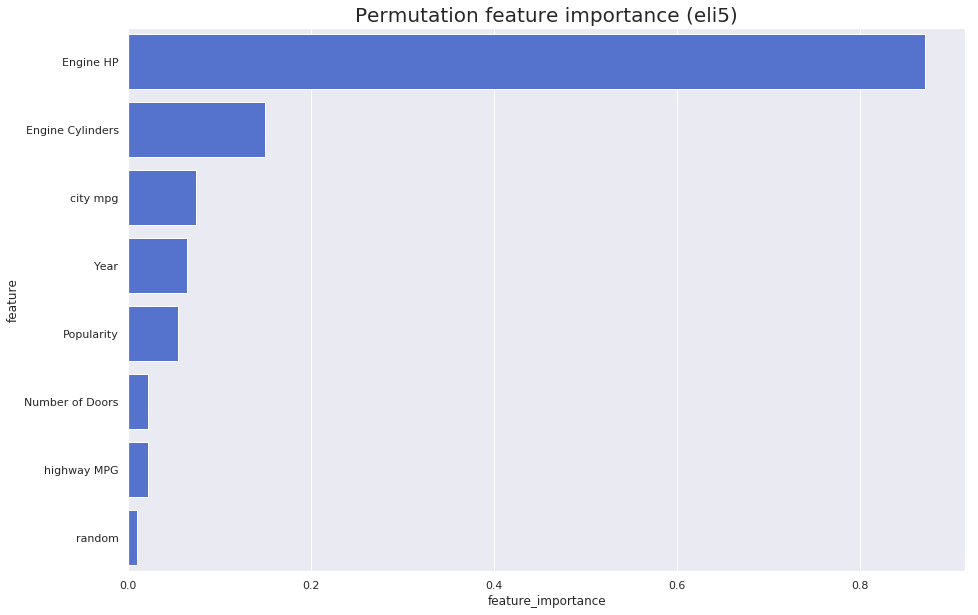

In [79]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf, cv = None, refit = False, n_iter = 50).fit(X_train, y_train)
perm_imp_eli5 = imp_df(X_train.columns, perm.feature_importances_)
var_imp_plot(perm_imp_eli5, 'Permutation feature importance (eli5)')

In [80]:
eli5.show_weights(perm)

Weight,Feature
0.8714 ± 0.0574,x1
0.1494 ± 0.0190,x2
0.0744 ± 0.0085,x5
0.0642 ± 0.0071,x0
0.0541 ± 0.0078,x6
0.0217 ± 0.0048,x3
0.0216 ± 0.0020,x4
0.0099 ± 0.0019,x7


Credit: https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e